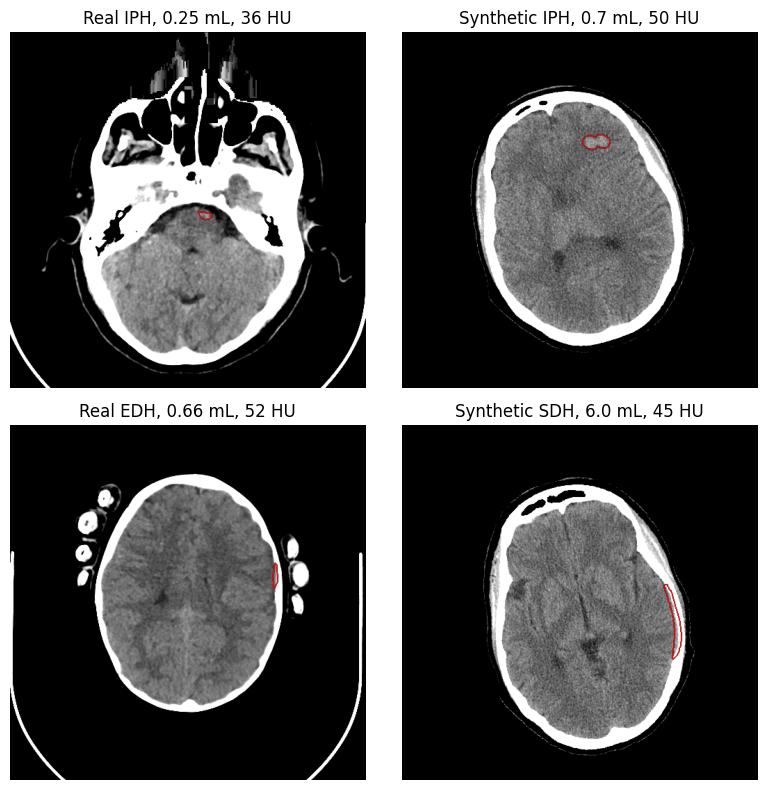

In [6]:
import sys
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from pathlib import Path
from VITools.image_acquisition import read_dicom

# options
mask_method = 'boundary' # 'boundary' or 'fill'
# paths
dataset_path = '../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1'
results_df = pd.read_csv('../datasets/real_dataset_predictions.csv')
# sort by Model_Output, ascending=True will give lowest predictive value first
results_df = results_df.sort_values(by='Model_Output', ascending=True)
# just visualize the cases with hemorrhage (we're looking at the false negatives)
lesion_present_IDs = results_df[results_df['Any_ICH'] == 1]['Patient Number'].tolist()

real_false_negatives = [58, 67]

nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*nrows, 4*ncols))
axs = axs.flat

# plot two Hssayeni false positives (two lowest predictive values)
for idx, patient in enumerate(real_false_negatives):
    model_pred = round(results_df[results_df['Patient Number'] == patient]['Model_Output'].item(), 4)
    patient = str(patient).zfill(3)
    
    img_vol = np.rot90(nib.load(dataset_path + '/ct_scans/' + patient + '.nii').get_fdata(), 1)
    mask = np.rot90(nib.load(dataset_path + '/masks/' + patient + '.nii').get_fdata(), 1)
    mask = np.where(mask > 0, 1, 0) # binarize mask

    # find slice with most hemorrhage voxels
    pixel_counts = []
    for i in range(mask.shape[-1]):
        pixel_counts.append(np.sum(mask[:, :, i]))

    if mask_method == 'boundary':
        mask = ski.segmentation.find_boundaries(mask[:, :, np.argmax(pixel_counts)].astype('bool'), mode='thick', background=0)
        alpha = 1.0
        cmap='bwr_r'
    else:
        # mask_method == 'fill'
        alpha = 0.5
        cmap='Reds_r'

    # plot
    new_mask = np.ma.masked_where(mask == False, mask)
    axs[idx*2].imshow(img_vol[:, :, np.argmax(pixel_counts)], vmin=0, vmax=80, cmap='gray') # show img
    axs[idx*2].imshow(new_mask, cmap=cmap, alpha=alpha)

    #axs[idx*2].set_title(f'{patient}\nmodel prediction: {model_pred}')
    if idx == 0:
        axs[idx*2].set_title(f'Real IPH, 0.25 mL, 36 HU')
    else:
        axs[idx*2].set_title(f'Real EDH, 0.66 mL, 52 HU')
    axs[idx*2].axis('off')

## GET SYNTHETIC DATA AND PLOT
mask_method = 'boundary' # 'boundary' or 'fill'
study_name = 'manuscript_100_280mA_wME'
base_dir = Path('/projects01/didsr-aiml/jayse.weaver/insilicoich/') / study_name

#metadata = pd.concat([pd.read_csv(o) for o in base_dir.rglob('metadata*.csv')], ignore_index=True).sort_values(by=['name', 'image file']).reset_index(drop=True)
metadata = pd.read_csv(str(base_dir / study_name) + '_CAD_1_metadata.csv')
metadata.loc[~metadata['LesionAttenuation(HU)'].isna(), 'Subtype'] = metadata[~metadata['LesionAttenuation(HU)'].isna()]['Subtype'].apply(lambda x: x.split("['")[-1].split("']")[0])
metadata.loc[~metadata['LesionAttenuation(HU)'].isna(), 'LesionAttenuation(HU)'] = metadata[~metadata['LesionAttenuation(HU)'].isna()]['LesionAttenuation(HU)'].apply(lambda x: float(x.split('[')[-1].split(']')[0])).astype(int)
metadata['LesionVolume(mL)'] = metadata['LesionVolume(mL)'].apply(lambda x: float(x.split('[')[-1].split(']')[0]))
metadata['ImageFilePath']=metadata['ImageFilePath'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))
metadata.loc[~metadata['MaskFilePath'].isna(), 'MaskFilePath']=metadata.loc[~metadata['MaskFilePath'].isna(), 'MaskFilePath'].apply(lambda x: base_dir / str(x.split(study_name+'/')[-1]))

for n in metadata['Name'].unique():
    metadata.loc[metadata['Name'] == n, 'Slice'] = list(range(len( metadata[metadata['Name'] == n])))
metadata['Slice'] = metadata['Slice'].astype(int)

metadata[~metadata['Name'].duplicated()]

#from utils import ctshow
window = 'brain'
# NEW FIGURE (focus on correctly identified cases)
cases = ['case_092', 'case_059']

slice_averaging = True # True -> 5mm , False -> 1mm

for idx, ax in enumerate(cases):
    case = cases[idx]
    z = metadata[(metadata['Name'] == case) & (metadata['LesionVolume(mL)']>0)]['CenterZ'].iloc[0].astype(int)
    
    if not slice_averaging:
        mask = read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z)]['MaskFilePath'].item())
        img = read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z)]['ImageFilePath'].item())
    else:
        img = read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z-2)]['ImageFilePath'].item())
        img = img + read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z-1)]['ImageFilePath'].item())
        img = img + read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z)]['ImageFilePath'].item())
        img = img + read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z+1)]['ImageFilePath'].item())
        img = img + read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z+2)]['ImageFilePath'].item())
        img = img/5

        mask = read_dicom(metadata[(metadata['Name'] == case) & (metadata['Slice']==z)]['MaskFilePath'].item())

    if mask_method == 'boundary':
        labels, num = ski.measure.label(mask, background=0, connectivity=1, return_num=True)
        assert( labels.max() != 0 )
        largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
        mask = ski.segmentation.find_boundaries(largestCC.astype('bool'), mode='thick', background=0)
        # mask = ski.segmentation.find_boundaries(mask.astype('bool'), mode='thick', background=0)
        alpha = 1.0
        cmap='bwr_r'
    else:
        # mask_method == 'fill'
        alpha = 0.5
        cmap='Reds_r'

    age =  metadata[metadata['Name'] == case].iloc[z]['Age'].astype(int)
    
    lesion_type = metadata[metadata['Name'] == case].iloc[z]['Subtype']
    vol =  metadata[metadata['Name'] == case]['LesionVolume(mL)'].sum()
    intensity = metadata[metadata['Name'] == case].iloc[z]['LesionAttenuation(HU)']
    
    new_mask = np.ma.masked_where(mask == 0, mask)
    axs[idx*2+1].imshow(img, cmap='gray', vmin=0, vmax=80)
    axs[idx*2+1].imshow(new_mask, cmap=cmap, alpha=alpha)

    if lesion_type == 'round':
        lesion_type = 'IPH'
    if lesion_type == 'subdural':
        lesion_type = 'SDH'
    if lesion_type == 'epidural':
        lesion_type = 'EDH'
    if idx == 0:
        axs[idx*2+1].set_title(f'Synthetic {lesion_type}, {vol:2.1f} mL, {intensity:2.0f} HU')
    else:
        axs[idx*2+1].set_title(f'Synthetic {lesion_type}, {vol:2.1f} mL, {intensity:2.0f} HU')
    axs[idx*2+1].axis('off')

plt.tight_layout()